Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.6886 - val_loss: 0.7616
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.6435 - val_loss: 0.6868
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5775 - val_loss: 0.6192
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5189 - val_loss: 0.5567
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.4502 - val_loss: 0.4999
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3989 - val_loss: 0.4475
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.3451 - val_loss: 0.3998
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.3092 - val_loss: 0.3559
Epoch 9/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2788 - val_loss: 0.3166
Epoch 10/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2371 - val_loss: 0.2823
Epoch 11/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.2126 - val_loss: 0.2515
Epoch 12/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.2012 - val_lo

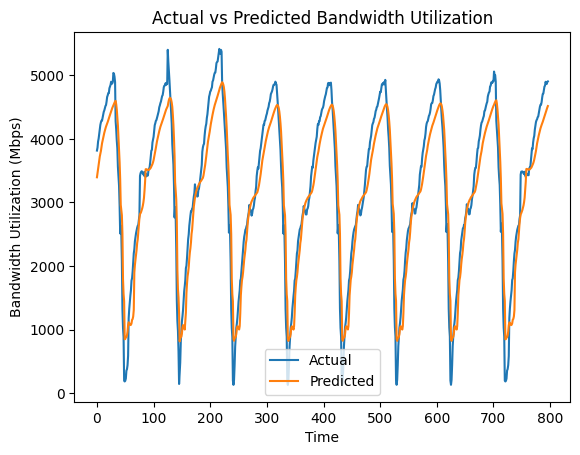

In [10]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping


data = pd.read_excel('Dataset_assigment_01032024.xlsx', sheet_name='Data')


if not pd.api.types.is_datetime64_any_dtype(data['Date']):

    data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'])
else:

    data['Timestamp'] = data['Date']


data.set_index('Timestamp', inplace=True)


data = data.drop(['Date', 'Time'], axis=1)


scaler = StandardScaler()
data['Mbps'] = scaler.fit_transform(data['Mbps'].values.reshape(-1, 1))

train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]


def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length]['Mbps'].values
        target = data.iloc[i+seq_length]['Mbps']
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

seq_length = 10
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)

input_layer = layers.Input(shape=(seq_length,))
reshape_layer = layers.Reshape((seq_length, 1))(input_layer)
positional_encoding_layer = PositionalEncoding(seq_length)(reshape_layer)


query_layer = layers.Dense(units=2)(reshape_layer)
key_layer = layers.Dense(units=2)(reshape_layer)
value_layer = layers.Lambda(lambda x: x)(positional_encoding_layer)

multi_head_attention_layer = layers.MultiHeadAttention(num_heads=2, key_dim=2, dropout=0.1)(
    query_layer, key_layer, value_layer
)


global_average_pooling_layer = layers.GlobalAveragePooling1D()(multi_head_attention_layer)


output_layer = layers.Dense(1)(global_average_pooling_layer)


model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001), loss='mean_squared_error')


early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping])


y_pred = model.predict(X_test)

y_pred_original_scale = scaler.inverse_transform(y_pred)
y_test_original_scale = scaler.inverse_transform(y_test.reshape(-1, 1))


mae = mean_absolute_error(y_test_original_scale, y_pred_original_scale)
mse = mean_squared_error(y_test_original_scale, y_pred_original_scale)
rmse = np.sqrt(mse)

print(f'MAE: {mae}, MSE: {mse}, RMSE: {rmse}')


plt.plot(y_test_original_scale, label='Actual')
plt.plot(y_pred_original_scale, label='Predicted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Bandwidth Utilization (Mbps)')
plt.title('Actual vs Predicted Bandwidth Utilization')
plt.savefig('actual_vs_predicted.pdf')
plt.show()
